In [1]:
from pathlib import Path
from mea_flow.data import load_data

# Dataset configuration
data_path = '/media/neuro/Data/MEA-data/'
conditions = ['control', 'chronic-stress', 'miR-186-5p-inhibition']
filenames = ['n1-DIV17-01.mat', 'n2-DIV17-01.mat', 'n3-DIV17-01.mat']  # Use .mat files

# Load datasets into condition-based dictionary
spike_lists = {}

for condition, filename in zip(conditions, filenames):
    file_path = Path(data_path) / filename
    spike_lists[condition] = load_data(
        file_path=file_path,
        data_format='mat',
        channels_key='Channels',
        times_key='Times',
        time_unit='s'  # Times are already in seconds in the .mat file
    )

/home/neuro/repos/mea-flow/src/mea_flow/analysis/synchrony.py:19: UserWarning: PySpike not available. Some synchrony metrics will be disabled.
  warnings.warn("PySpike not available. Some synchrony metrics will be disabled.")
/home/neuro/repos/mea-flow/src/mea_flow/manifold/embedding.py:26: UserWarning: UMAP not available. UMAP embedding will be disabled.
  warnings.warn("UMAP not available. UMAP embedding will be disabled.")


# Analysis of MEA data

With this example, we demonstrate the analysis capabilities of MEA-flow. It incorporates comprehensive analysis routines for multi-unit activity analysis and to simplify the comparison across different experimental conditions. This workflow provides:

- **Comprehensive metrics**: 25+ activity, regularity, synchrony, and *burstiness* metrics
- **Multiple analysis levels**: Global, well-based, temporal, and channel-level
- **Statistical comparisons**: Automated pairwise testing between conditions
- **Rich visualizations**: Raster plots, metric comparisons, temporal dynamics
- **Data export**: CSV files for all results and summary statistics
- **Modular approach**: Use individual components or the complete pipeline

## Available Metric catogories
(a complete and detailed description of these methods is provided in [ACTIVITY_ANALYSIS_METHODS_REFERENCE.md](ACTIVITY_ANALYSIS_METHODS_REFERENCE.md))

##### Activity Metrics:
- `mean_firing_rate`, `std_firing_rate`, `median_firing_rate`, `max_firing_rate`, `min_firing_rate`
- `total_spike_count`, `mean_spike_count`, `std_spike_count`
- `active_channels_count`, `total_channels`, `activity_fraction`
- `network_firing_rate`, `fano_factor_mean`
- `pop_vector_length_mean`, `pop_vector_length_std`
- `participation_ratio_mean`, `participation_ratio_std`
- `global_activity_cv`

##### Regularity Metrics:
- `cv_isi_mean`, `cv_isi_std` (Coefficient of Variation of ISIs)
- `lv_isi_mean`, `lv_isi_std` (Local Variation of ISIs)
- `entropy_isi_mean`, `entropy_isi_std` (ISI entropy)
- `fano_factor_mean`, `fano_factor_std` (Spike count variability)

##### Synchrony Metrics:

- `pearson_cc_mean`, `pearson_cc_std`, `pearson_cc_median`, `pearson_cc_max`, `pearson_cc_min`
- `isi_distance`, `spike_distance`, `spike_sync_distance` (PySpike measures)
- `van_rossum_distance_mean`, `van_rossum_distance_std`
- `chi_square_distance`, `cosyne_similarity`, `synchrony_index`

##### Burst Metrics:
- `burst_rate_mean`, `burst_duration_mean`, `bursts_per_channel_mean`
- `network_burst_rate`, `network_burst_duration_mean`
- `burst_participation_ratio`

In this example, we are only going to perform a `global` analysis where we compare the entire recording across the different conditions. But the different analysis types and variants are also added for demonstration purposes. We start by specifying the analysis configurations and parameters:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mea_flow.analysis import MEAMetrics, AnalysisConfig
from mea_flow.visualization import MEAPlotter
from mea_flow.data import SpikeList

# Configure analysis parameters
config = AnalysisConfig(
    time_bin_size=1.0,           # 1 second bins for activity analysis
    min_spikes_for_rate=10,      # Minimum spikes to consider channel active
    min_isi_samples=5,           # Minimum ISIs for regularity metrics
    n_pairs_sync=500,            # Max pairs for synchrony analysis (computational limit)
    sync_time_bin=0.01,          # 10ms bins for correlation analysis
    tau_van_rossum=0.02,         # 20ms time constant for van Rossum distance
    burst_detection=True,        # Enable burst detection
    network_burst_detection=True, # Enable network burst detection
    min_burst_spikes=5,          # Minimum spikes per burst
    max_isi_burst=0.1,           # 100ms max ISI within burst
    network_burst_threshold=1.25, # Threshold for network burst detection
    min_network_burst_duration=0.05, # 50ms minimum network burst duration
    min_electrodes_active=0.35   # 35% of electrodes must be active for network burst
)

# Initialize metrics calculator and plotter
metrics_calc = MEAMetrics(config, verbose=True)
plotter = MEAPlotter()

In [4]:
# Assuming you have: spike_lists = {'condition1': spike_list1, 'condition2': spike_list2, 'condition3': spike_list3}

# Option A: Global analysis (entire recording per condition)
results_global = metrics_calc.compare_conditions(
    spike_lists, 
    grouping='global'
)
results_global


Analyzing 3 experimental conditions...


Processing: control:   0%|          | 0/3 [00:00<?, ?condition/s]  


Computing MEA metrics for 64 active channels...
Recording length: 330.0s


Processing: chronic-stress:  33%|███▎      | 1/3 [00:03<00:06,  3.26s/condition]


Computing MEA metrics for 64 active channels...
Recording length: 330.0s


Processing: miR-186-5p-inhibition:  67%|██████▋   | 2/3 [00:05<00:02,  2.65s/condition]


Computing MEA metrics for 64 active channels...
Recording length: 330.0s


Processing: miR-186-5p-inhibition: 100%|██████████| 3/3 [00:07<00:00,  2.42s/condition]


All 3 conditions processed successfully!


,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,active_channels_count,...,network_burst_spikes_mean,network_burst_spikes_std,network_burst_peak_activity_mean,network_burst_peak_activity_std,inter_network_burst_interval_mean,inter_network_burst_interval_std,group_type,group_id,n_channels,recording_length
0,control,92.690914,26.808077,91.244596,160.407216,44.760928,1957618,30587.781250,8846.601592,64,...,3790.100719,3417.634163,151.381295,24.971464,2.162899,2.238878,global,all,64,329.997624
1,chronic-stress,38.418214,10.569137,38.153580,62.455445,18.548752,811381,12677.828125,3487.764912,64,...,1247.915556,1024.560080,95.160000,23.633520,1.327723,1.112842,global,all,64,329.995248
2,miR-186-5p-inhibition,10.042631,3.238903,9.654927,18.706799,4.421387,212092,3313.937500,1068.795860,64,...,553.257576,359.466010,53.840909,14.377397,2.259847,2.659705,global,all,64,329.986976


In [5]:

# Option B: Well-based analysis (if you have multi-well plates)
results_wells = metrics_calc.compare_conditions(
    spike_lists, 
    grouping='well'
)
results_wells


Analyzing 3 experimental conditions...


Processing: miR-186-5p-inhibition: 100%|██████████| 3/3 [00:08<00:00,  2.75s/condition]


All 3 conditions processed successfully!


,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,active_channels_count,...,network_burst_spikes_mean,network_burst_spikes_std,network_burst_peak_activity_mean,network_burst_peak_activity_std,inter_network_burst_interval_mean,inter_network_burst_interval_std,group_type,group_id,n_channels,recording_length
0,control,104.466472,29.450876,112.193232,160.407216,44.760928,551579,34473.6875,9718.719255,16,...,2114.163793,1166.851651,74.844828,18.861840,2.578870,2.183213,well,1,16,329.997624
1,control,92.306346,18.012014,92.023390,122.300881,54.867062,487374,30460.8750,5943.921842,16,...,1787.693548,1243.703044,68.056452,15.311445,2.391220,2.718266,well,2,16,329.997624
2,control,99.640490,29.016119,94.946138,140.613134,55.257974,526098,32881.1250,9575.250172,16,...,1724.700000,1345.219375,70.078571,18.680038,2.148129,2.850874,well,3,16,329.997624
3,control,74.350346,17.818117,78.285412,116.334171,45.306387,392567,24535.4375,5879.936160,16,...,1967.100000,1080.491985,67.780000,14.234170,2.938081,3.494623,well,4,16,329.997624
4,chronic-stress,40.369331,8.119638,39.405113,62.243321,21.445763,213147,13321.6875,2679.441820,16,...,946.281046,594.239322,60.065359,12.176090,1.954211,1.367024,well,1,16,329.995248
5,chronic-stress,29.549289,6.964447,28.570108,45.352168,19.512402,156018,9751.1250,2298.234319,16,...,795.858108,373.334826,54.418919,11.784101,2.024694,2.091276,well,2,16,329.995248
6,chronic-stress,45.367699,9.953745,41.999090,62.455445,30.985295,239538,14971.1250,3284.688605,16,...,858.097826,566.042796,56.233696,13.972207,1.588142,1.857207,well,3,16,329.995248
7,chronic-stress,38.386538,10.127019,39.806634,56.670513,18.548752,202678,12667.3750,3341.868001,16,...,908.697183,577.887642,59.612676,12.314453,2.049291,1.359245,well,4,16,329.995248
8,miR-186-5p-inhibition,9.064941,2.627480,8.788226,16.182457,5.551734,47861,2991.3125,867.034149,16,...,479.178082,218.815951,43.958904,9.832067,4.061806,2.963938,well,1,16,329.986976
9,miR-186-5p-inhibition,9.978424,3.197600,9.157937,15.164235,5.248692,52684,3292.7500,1055.166190,16,...,422.988764,182.098781,36.696629,9.418371,3.162273,5.327819,well,2,16,329.986976


In [ ]:
# Option C: Time-windowed analysis (temporal dynamics)
results_temporal = metrics_calc.compare_conditions(
    spike_lists, 
    grouping='time',
    group_params={'window_length': 5.0}  # 5-second windows
)
results_temporal


Analyzing 3 experimental conditions...


Processing: miR-186-5p-inhibition: 100%|██████████| 3/3 [00:14<00:00,  4.96s/condition]


All 3 conditions processed successfully!


,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,active_channels_count,...,van_rossum_distance_std,chi_square_distance,population_spike_synchrony,synchrony_index,group_type,group_id,window_start,window_end,n_channels,recording_length
0,control,118.578125,73.364664,132.2,245.8,5.6,37945,592.890625,366.823319,64,...,122.685853,23.138120,0.339217,1.000,time,0,0.0,5.0,64,5.0
1,control,90.506250,56.154318,80.4,206.8,4.6,28962,452.531250,280.771591,64,...,117.723255,15.698743,0.272810,1.000,time,1,5.0,10.0,64,5.0
2,control,66.931250,44.010527,63.2,173.0,2.2,21418,334.656250,220.052637,64,...,111.959572,9.441962,0.216754,1.000,time,2,10.0,15.0,64,5.0
3,control,115.228571,76.108034,116.6,296.2,5.0,36297,576.142857,380.540170,63,...,144.012618,25.085127,0.300691,1.000,time,3,15.0,20.0,64,5.0
4,control,74.162500,50.038471,76.6,200.4,7.0,23732,370.812500,250.192356,64,...,108.492304,10.736002,0.236094,1.000,time,4,20.0,25.0,64,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,miR-186-5p-inhibition,8.629167,3.825570,8.0,17.4,2.6,2071,43.145833,19.127848,48,...,30.666677,5.546286,0.129847,0.344,time,55,275.0,280.0,58,5.0
176,miR-186-5p-inhibition,11.200000,8.325925,9.6,34.2,2.0,2184,56.000000,41.629625,39,...,43.706547,4.769777,0.122925,0.404,time,56,280.0,285.0,54,5.0
177,miR-186-5p-inhibition,14.264706,7.327903,12.9,37.4,2.8,2425,71.323529,36.639516,34,...,46.619028,5.252062,0.185287,0.374,time,57,285.0,290.0,44,5.0
178,miR-186-5p-inhibition,14.306122,7.936699,14.0,39.2,2.6,3505,71.530612,39.683494,49,...,46.866418,5.503381,0.137288,0.500,time,58,290.0,295.0,59,5.0


In [ ]:
results_temporal

,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,active_channels_count,...,van_rossum_distance_std,chi_square_distance,population_spike_synchrony,synchrony_index,group_type,group_id,window_start,window_end,n_channels,recording_length
0,control,118.578125,73.364664,132.2,245.8,5.6,37945,592.890625,366.823319,64,...,122.685853,23.138120,0.339217,1.000,time,0,0.0,5.0,64,5.0
1,control,90.506250,56.154318,80.4,206.8,4.6,28962,452.531250,280.771591,64,...,117.723255,15.698743,0.272810,1.000,time,1,5.0,10.0,64,5.0
2,control,66.931250,44.010527,63.2,173.0,2.2,21418,334.656250,220.052637,64,...,111.959572,9.441962,0.216754,1.000,time,2,10.0,15.0,64,5.0
3,control,115.228571,76.108034,116.6,296.2,5.0,36297,576.142857,380.540170,63,...,144.012618,25.085127,0.300691,1.000,time,3,15.0,20.0,64,5.0
4,control,74.162500,50.038471,76.6,200.4,7.0,23732,370.812500,250.192356,64,...,108.492304,10.736002,0.236094,1.000,time,4,20.0,25.0,64,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,miR-186-5p-inhibition,8.629167,3.825570,8.0,17.4,2.6,2071,43.145833,19.127848,48,...,30.666677,5.546286,0.129847,0.344,time,55,275.0,280.0,58,5.0
176,miR-186-5p-inhibition,11.200000,8.325925,9.6,34.2,2.0,2184,56.000000,41.629625,39,...,43.706547,4.769777,0.122925,0.404,time,56,280.0,285.0,54,5.0
177,miR-186-5p-inhibition,14.264706,7.327903,12.9,37.4,2.8,2425,71.323529,36.639516,34,...,46.619028,5.252062,0.185287,0.374,time,57,285.0,290.0,44,5.0
178,miR-186-5p-inhibition,14.306122,7.936699,14.0,39.2,2.6,3505,71.530612,39.683494,49,...,46.866418,5.503381,0.137288,0.500,time,58,290.0,295.0,59,5.0


In [9]:
# Option D: Channel-level analysis (individual electrode analysis)
results_channels = metrics_calc.compare_conditions(
    spike_lists, 
    grouping='channel'
)
results_channels


Analyzing 3 experimental conditions...


Processing: miR-186-5p-inhibition: 100%|██████████| 3/3 [00:02<00:00,  1.20condition/s]


All 3 conditions processed successfully!


,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,active_channels_count,...,pearson_cc_std,isi_distance,spike_distance,spike_sync_distance,group_type,group_id,channel_id,n_channels,recording_length,well_id
0,control,44.760928,0.0,44.760928,44.760928,44.760928,14771,14771.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,0,0,1,329.997624,1
1,control,119.955409,0.0,119.955409,119.955409,119.955409,39585,39585.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,1,1,1,329.997624,1
2,control,97.152215,0.0,97.152215,97.152215,97.152215,32060,32060.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,2,2,1,329.997624,1
3,control,59.973159,0.0,59.973159,59.973159,59.973159,19791,19791.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,3,3,1,329.997624,1
4,control,160.407216,0.0,160.407216,160.407216,160.407216,52934,52934.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,4,4,1,329.997624,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,miR-186-5p-inhibition,9.594318,0.0,9.594318,9.594318,9.594318,3166,3166.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,59,59,1,329.986976,4
188,miR-186-5p-inhibition,15.573342,0.0,15.573342,15.573342,15.573342,5139,5139.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,60,60,1,329.986976,4
189,miR-186-5p-inhibition,4.421387,0.0,4.421387,4.421387,4.421387,1459,1459.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,61,61,1,329.986976,4
190,miR-186-5p-inhibition,14.073283,0.0,14.073283,14.073283,14.073283,4644,4644.0,0.0,1,...,NaN,NaN,NaN,NaN,channel,62,62,1,329.986976,4


In [10]:
# save dataframes
results_channels.to_csv('results_channels.csv')
results_wells.to_csv('results_wells.csv')
results_global.to_csv('results_global.csv')
results_temporal.to_csv('results_temporal.csv')


## Visualization

After obtaining the main results, we can visualize them using the MEAPlotter class. The package includes a lot of useful visualizations and different parameters to tweak the plot types, which we will demonstrate below. 



In [14]:
results_global.columns

Index(['condition', 'mean_firing_rate', 'std_firing_rate',
       'median_firing_rate', 'max_firing_rate', 'min_firing_rate',
       'total_spike_count', 'mean_spike_count', 'std_spike_count',
       'active_channels_count', 'total_channels', 'activity_fraction',
       'network_firing_rate', 'fano_factor_mean', 'pop_vector_length_mean',
       'pop_vector_length_std', 'participation_ratio_mean',
       'participation_ratio_std', 'global_activity_cv', 'cv_isi_mean',
       'cv_isi_std', 'cv_isi_median', 'lv_isi_mean', 'lv_isi_std',
       'lv_isi_median', 'lvr_isi_mean', 'lvr_isi_std', 'entropy_isi_mean',
       'entropy_isi_std', 'isi_5th_percentile_mean', 'isi_5th_percentile_std',
       'population_cv', 'fano_factor_std', 'channels_analyzed',
       'pearson_cc_mean', 'pearson_cc_std', 'pearson_cc_median',
       'pearson_cc_max', 'pearson_cc_min', 'n_pairs_analyzed', 'isi_distance',
       'spike_distance', 'spike_sync_distance', 'van_rossum_distance_mean',
       'van_rossum_dista

/home/neuro/repos/mea-flow/src/mea_flow/visualization/metrics.py:107: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(data=plot_data, x=grouping_col, y=metric, ax=ax,
/home/neuro/repos/mea-flow/src/mea_flow/visualization/metrics.py:107: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(data=plot_data, x=grouping_col, y=metric, ax=ax,
/home/neuro/repos/mea-flow/src/mea_flow/visualization/metrics.py:107: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(data=plot_data, x=grouping_col, y=metric, ax=ax,


Plot saved to: activity_comparison.png


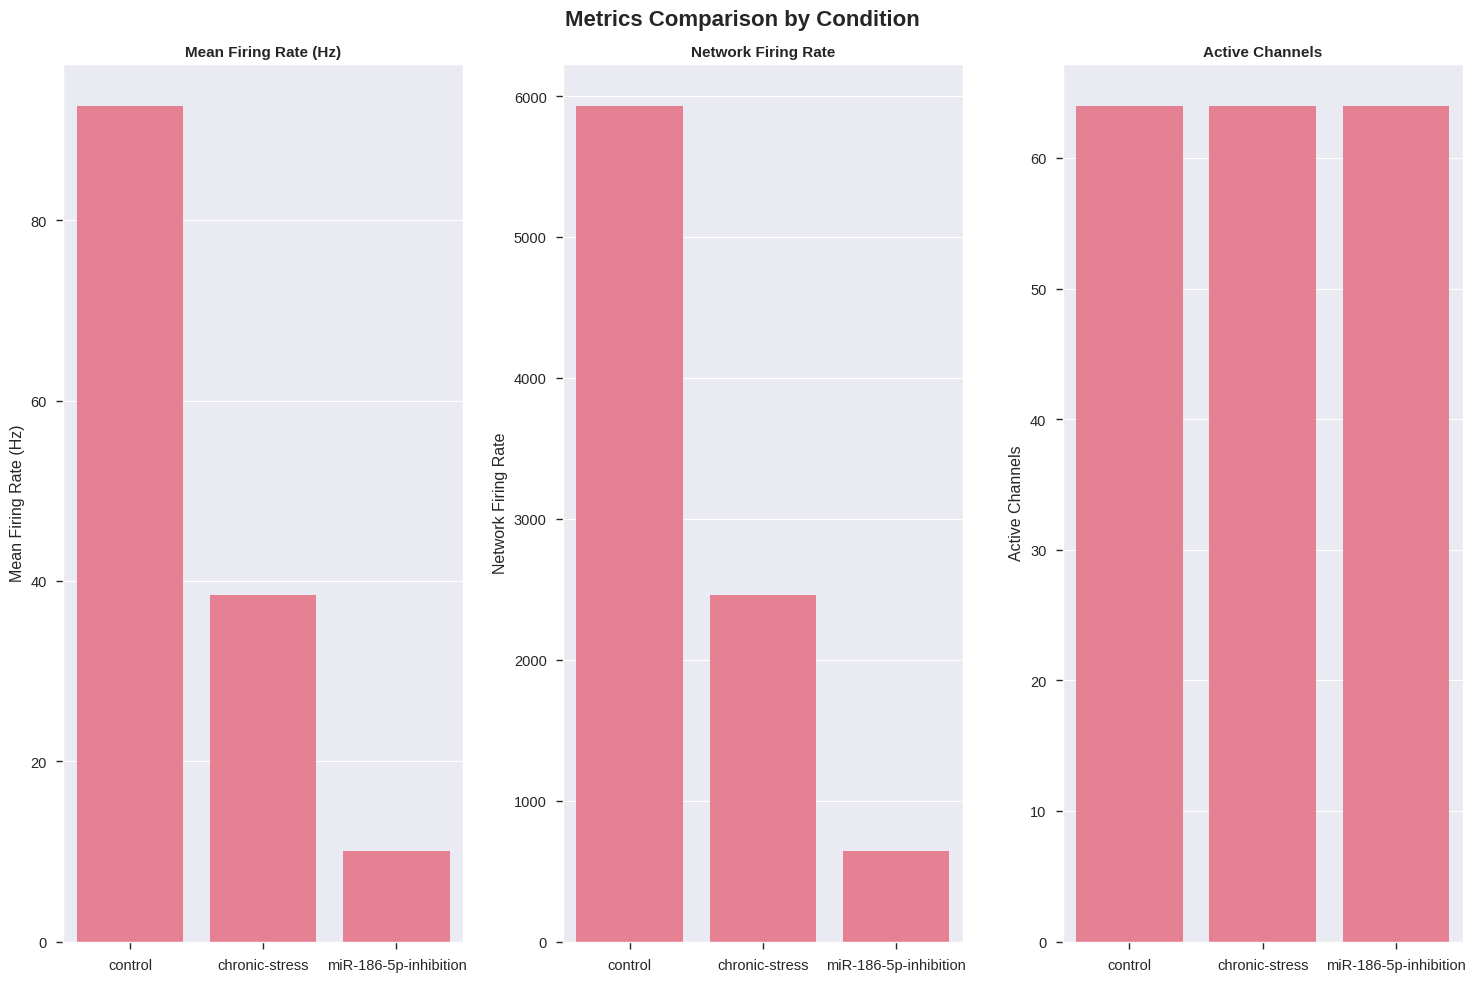

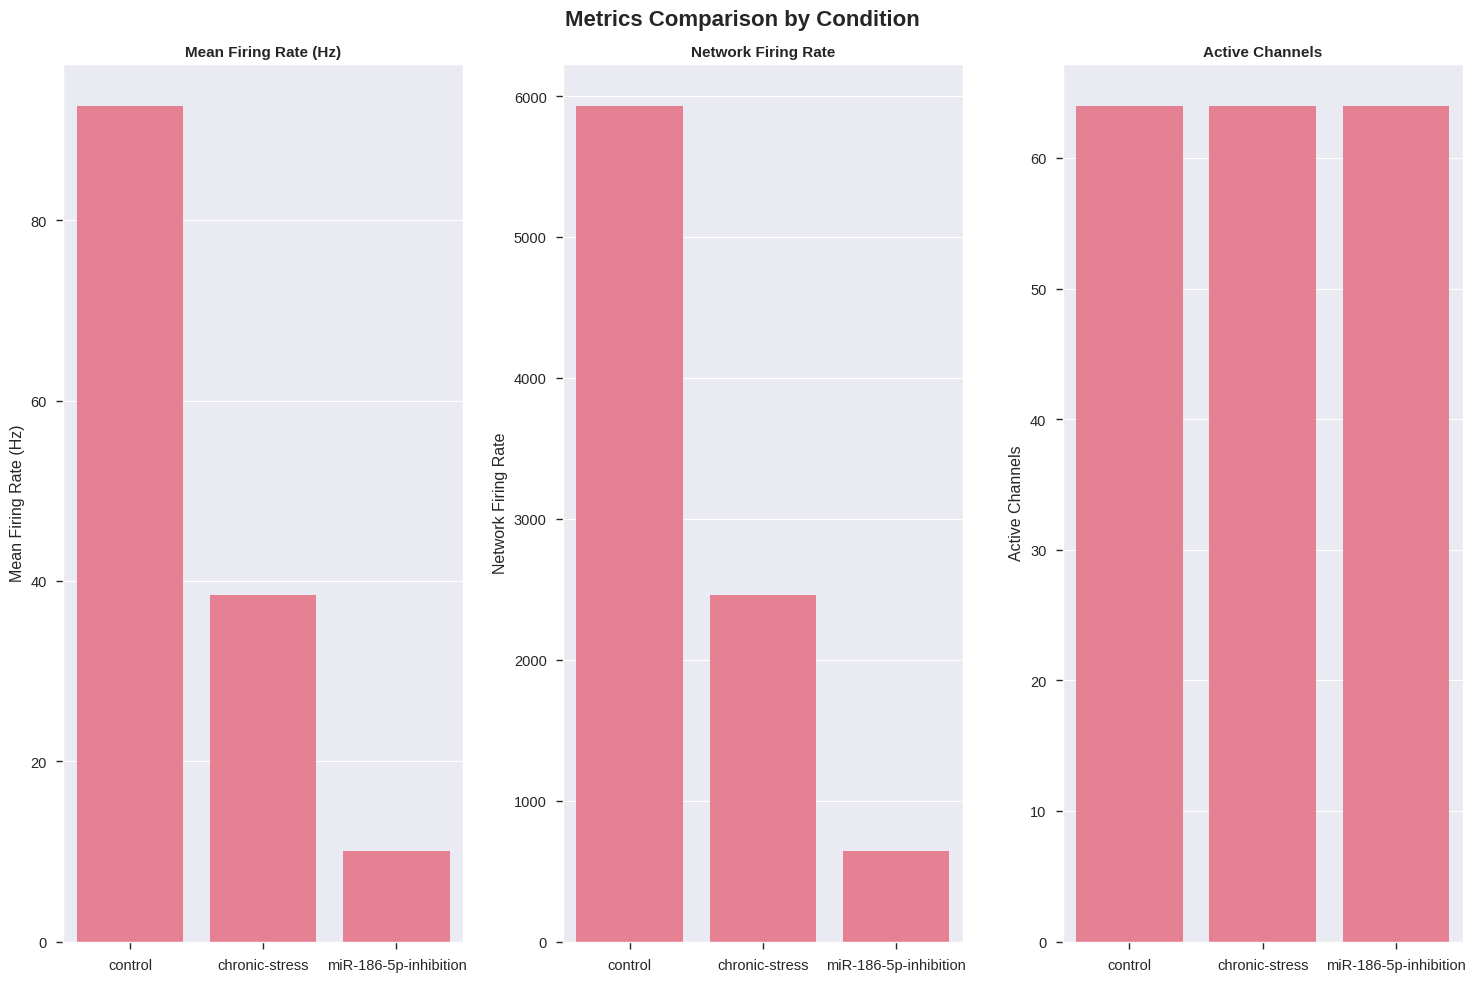

In [15]:
plotter.plot_metrics_comparison(
    results_global, 
    metrics=['mean_firing_rate', 'network_firing_rate', 'active_channels_count'],
    group_by='condition',
    plot_type='bar',  # Perfect for single values!
    save_path='activity_comparison.png'
)

Plot saved to: activity_comparison.png


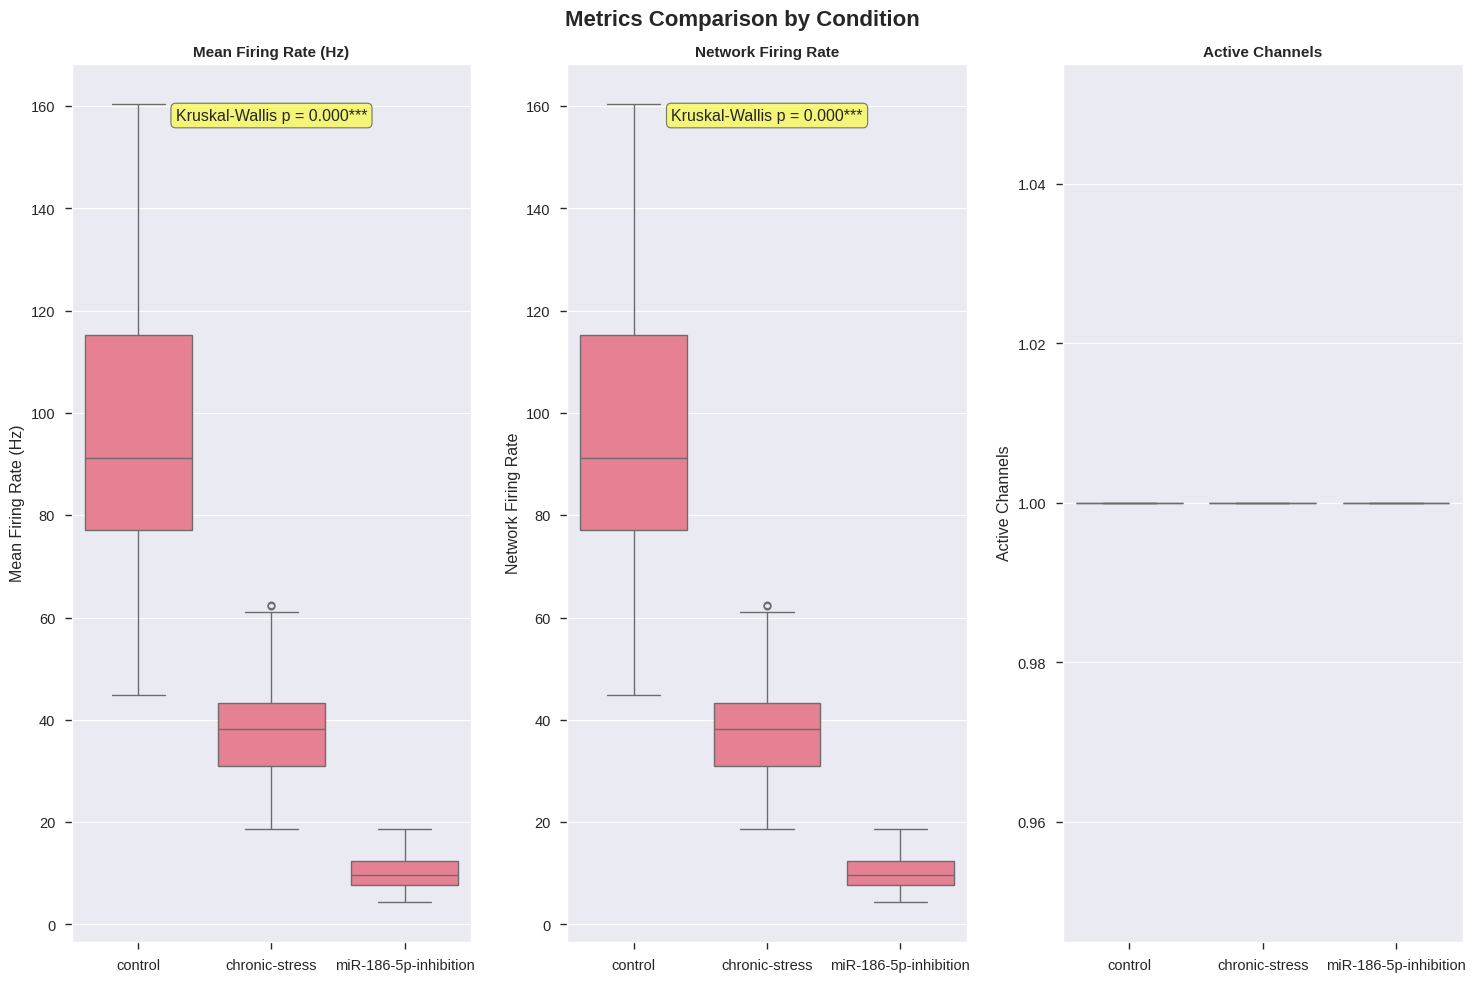

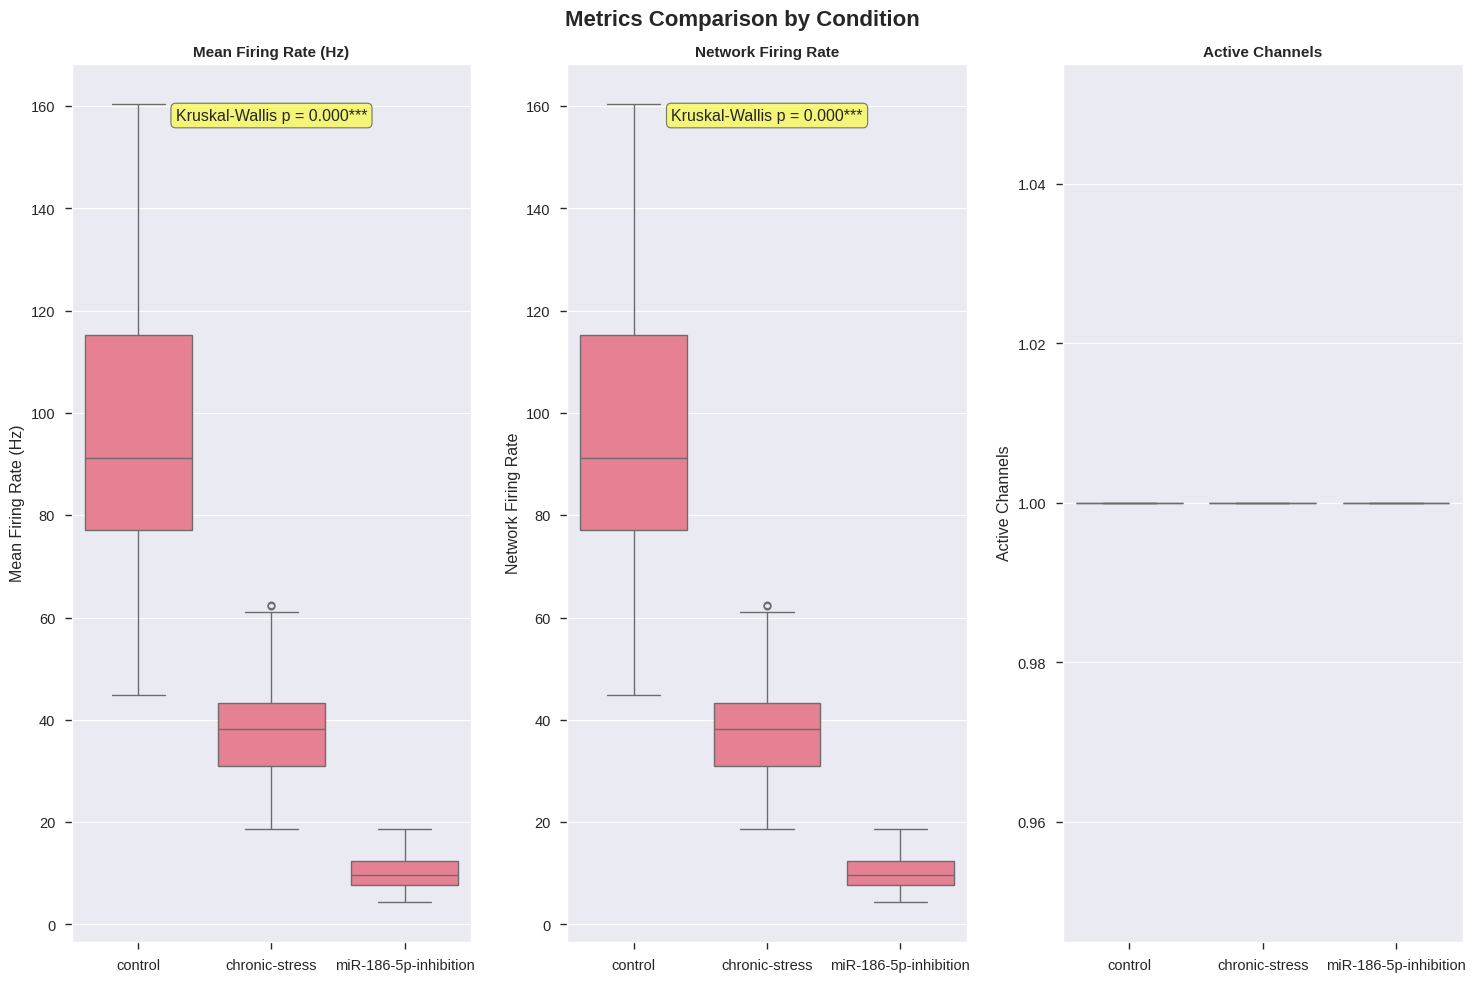

In [16]:
# Activity comparison across conditions
plotter.plot_metrics_comparison(
    results_channels, 
    metrics=['mean_firing_rate', 'network_firing_rate', 'active_channels_count'],
    group_by='condition',
    save_path='activity_comparison.png'
)

/home/neuro/repos/mea-flow/src/mea_flow/visualization/metrics.py:68: UserWarning: No valid metrics to plot
  warnings.warn("No valid metrics to plot")


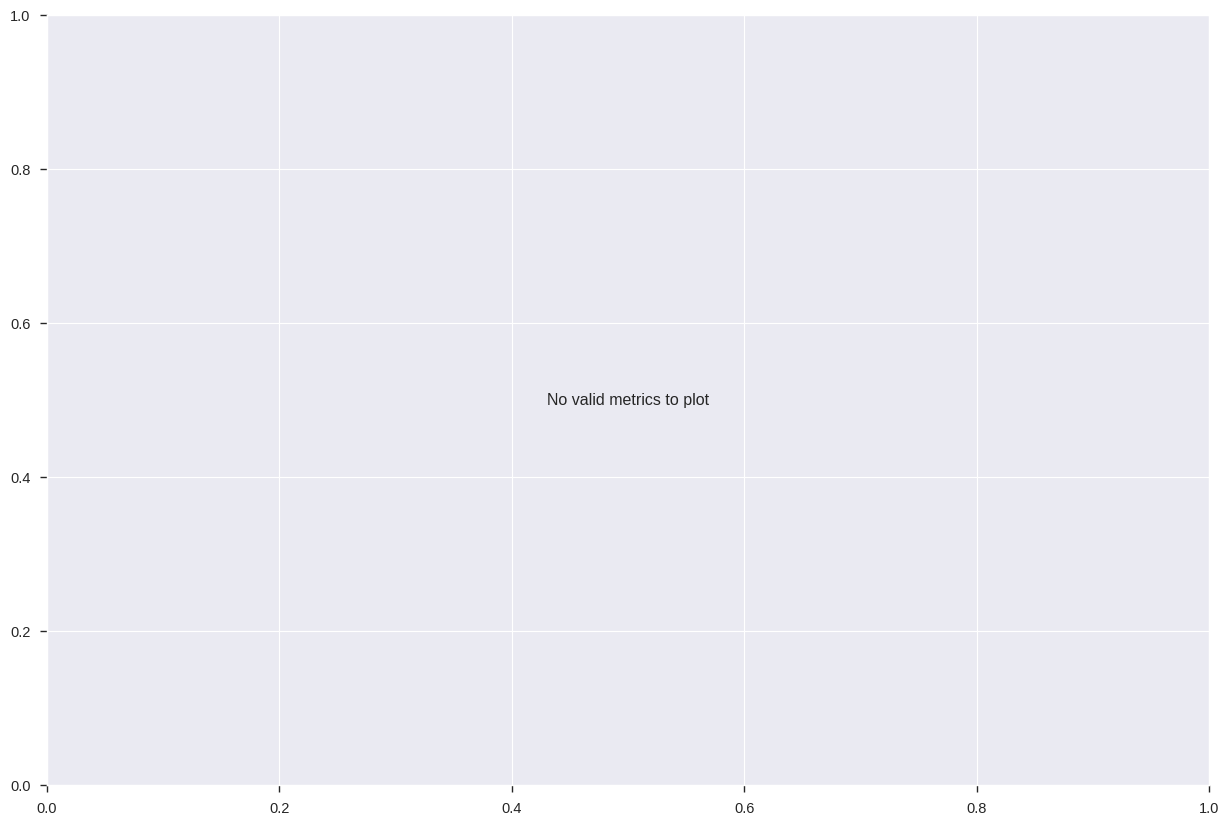

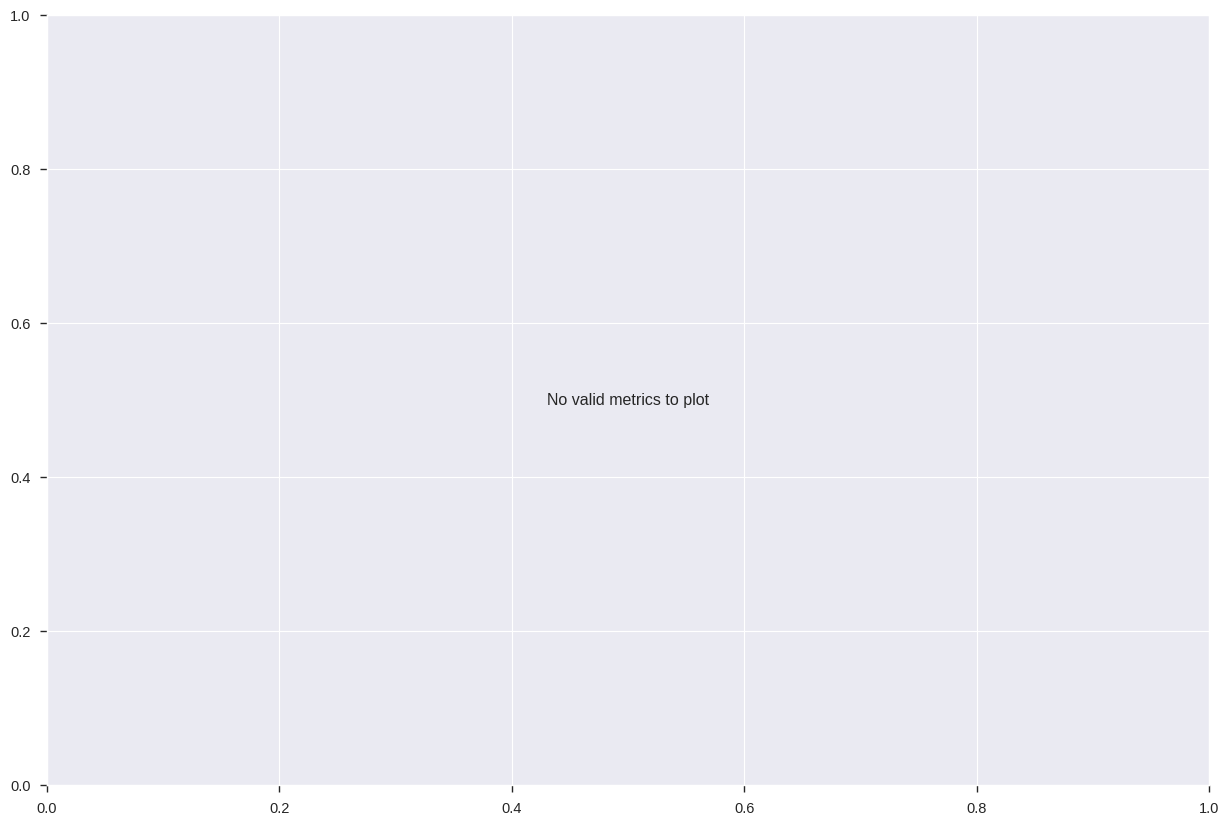

In [18]:
# Synchrony comparison
plotter.plot_metrics_comparison(
    results_channels,
    metrics=['pearson_cc_mean', 'synchrony_index', 'isi_distance'],
    group_by='condition',
    save_path='synchrony_comparison.png'
)